# Does the degree of urbanisation have a great influence on the quality of housing in terms of rooms per capita?

## Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

## Import Data

In [2]:
# # This will download ilc_lvho04d.tsv to the current working directory
# URL = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/ilc_lvho04d?format=TSV'
# response = requests.get(URL)
# open('estat_ilc_lvho04d.tsv', 'wb').write(response.content)

In [3]:
# # Ouverture du fichier de donnees avec comme separateur la tabulation \t
# df = pd.read_csv('estat_ilc_lvho04d.tsv', sep = '\t')

In [4]:
file_path = '/Users/apple/Desktop/project/datasets/estat_ilc_lvho04d.tsv'
    
# read the file into a dataframe
df = pd.read_csv(file_path, sep = '\t')

## Data Cleaning

In [5]:
# Renaming the first column for clarity and simplifying the code.
df = df.rename(columns={list(df.columns.values)[0]: 'country'})

In [6]:
# Creation of data frames for deg1, deg2, and deg3.
df_deg1 = df[df['country'].str.contains('DEG1')]
df_deg2 = df[df['country'].str.contains('DEG2')]
df_deg3 = df[df['country'].str.contains('DEG3')]

In [7]:
# Replacement of the first column with country names while keeping the last two characters.
df_deg1['country']= df_deg1.country.str[-2:]
df_deg2['country']= df_deg2.country.str[-2:]
df_deg3['country']= df_deg3.country.str[-2:]


/var/folders/7x/xdhd27715693yb5v5jhc6rd80000gn/T/ipykernel_55123/607105662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deg1['country']= df_deg1.country.str[-2:]
/var/folders/7x/xdhd27715693yb5v5jhc6rd80000gn/T/ipykernel_55123/607105662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deg2['country']= df_deg2.country.str[-2:]
/var/folders/7x/xdhd27715693yb5v5jhc6rd80000gn/T/ipykernel_55123/607105662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [8]:
# List of countries.
country_list=['AL','AT','BE','BG','CH','CY','CZ','DE','DK','EL','ES','FI','FR','HR','HU','IE','IS','IT','LT','LU',
              'LV','MK','MT','NL','NO','PL','PT','RO','RS','SE','SI','SK','UK']
country_dico={"AL":"Albania","AT":"Austria","BE":"Belgium","BG":"Bulgaria","CH":"Switzerland","CY":"Cyprus",
              "CZ":"Czechia","DE":"Germany","DK":"Denmark","EL":"Greece","ES":"Spain","FI":"Finland",
              "FR":"France","HR":"Croatia","HU":"Hungary","IE":"Ireland","IS":"Iceland","IT":"Italy",
              "LT":"Lithuania","LU":"Luxembourg","LV":"Latvia","MK":"North Macedonia","MT":"Malta ",
              "NL":"Netherlands","NO":"Norway","PL":"Poland","PT":"Portugal","RO":"Romania","RS":"Serbia",
              "SE":"Sweden","SI":"Slovenia","SK":"Slovakia","UK":"United Kingdom"}

In [9]:
# Removal of country groups, keeping only individual countries
df_deg1 = df_deg1[df_deg1['country'].str.contains('|'.join(country_list))]
df_deg2 = df_deg2[df_deg2['country'].str.contains('|'.join(country_list))]
df_deg3 = df_deg3[df_deg3['country'].str.contains('|'.join(country_list))]

In [10]:
# Replacing the 'country' column with the country names from the dictionary.
df_deg1['country'] = df_deg1['country'].map(country_dico)
df_deg2['country'] = df_deg2['country'].map(country_dico)
df_deg3['country'] = df_deg3['country'].map(country_dico)

In [11]:
# # Conversion of data to float NAN if error
# df_deg1.iloc[:, 1:] = df_deg1.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
# df_deg2.iloc[:, 1:] = df_deg2.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
# df_deg3.iloc[:, 1:] = df_deg3.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

In [12]:
# deleting the blanks in the column names
df_deg1.columns = df_deg1.columns.str.strip()
df_deg2.columns = df_deg2.columns.str.strip()
df_deg3.columns = df_deg3.columns.str.strip()

In [13]:
# define the columns names
time_periods = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', 
                '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# reduce non-numeric characters in each dataframe
for year in time_periods:
    df_deg1[year] = df_deg1[year].str.replace(r'[^0-9.]', '', regex=True)
    df_deg2[year] = df_deg2[year].str.replace(r'[^0-9.]', '', regex=True)
    df_deg3[year] = df_deg3[year].str.replace(r'[^0-9.]', '', regex=True)

# convert the columns to numeric
df_deg1[time_periods] = df_deg1[time_periods].apply(pd.to_numeric, errors='coerce')
df_deg2[time_periods] = df_deg2[time_periods].apply(pd.to_numeric, errors='coerce')
df_deg3[time_periods] = df_deg3[time_periods].apply(pd.to_numeric, errors='coerce')

In [14]:
# Resetting the index
df_deg1 = df_deg1.reset_index(drop=True)
df_deg2 = df_deg2.reset_index(drop=True)
df_deg3 = df_deg3.reset_index(drop=True)

In [15]:
# overview of the dataframe deg1
df_deg1.describe()

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,6.000000,14.000000,27.000000,27.000000,29.000000,29.000000,29.000000,31.000000,31.000000,30.000000,...,30.000000,31.000000,32.000000,33.000000,33.000000,32.000000,31.000000,30.000000,29.000000,28.000000
mean,1.616667,1.585714,1.477778,1.492593,1.500000,1.503448,1.524138,1.490323,1.535484,1.563333,...,1.523333,1.538710,1.509375,1.500000,1.509091,1.490625,1.493548,1.530000,1.579310,1.603571
std,0.263944,0.253763,0.386636,0.407550,0.411443,0.409253,0.400585,0.409353,0.385183,0.350845,...,0.355919,0.358401,0.358635,0.380789,0.375303,0.366641,0.371426,0.369669,0.361919,0.330524
min,1.100000,1.100000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,1.000000,...,1.000000,0.900000,0.900000,0.800000,0.800000,0.800000,0.800000,0.800000,1.000000,1.100000
25%,1.625000,1.425000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.200000,1.300000,...,1.200000,1.200000,1.175000,1.200000,1.200000,1.100000,1.150000,1.200000,1.200000,1.375000
50%,1.700000,1.550000,1.600000,1.600000,1.600000,1.500000,1.600000,1.500000,1.500000,1.500000,...,1.550000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000,1.600000
75%,1.775000,1.775000,1.750000,1.800000,1.800000,1.800000,1.800000,1.800000,1.800000,1.800000,...,1.800000,1.800000,1.725000,1.700000,1.800000,1.725000,1.750000,1.800000,1.900000,1.900000
max,1.800000,2.100000,2.200000,2.100000,2.100000,2.100000,2.200000,2.100000,2.200000,2.200000,...,2.100000,2.100000,2.100000,2.200000,2.200000,2.200000,2.200000,2.300000,2.300000,2.100000


In [16]:
# overview of the dataframe deg2
df_deg2.describe()

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,6.000000,13.000000,25.000000,25.000000,27.000000,27.000000,27.000000,29.000000,29.00000,29.000000,...,30.000000,31.000000,32.000000,33.000000,33.000000,32.00000,31.000000,30.000000,29.000000,28.000000
mean,1.683333,1.715385,1.568000,1.576000,1.570370,1.577778,1.596296,1.555172,1.57931,1.617241,...,1.586667,1.619355,1.581250,1.578788,1.603030,1.58125,1.600000,1.626667,1.662069,1.707143
std,0.292689,0.247811,0.419047,0.420595,0.419537,0.407934,0.417393,0.451653,0.43456,0.396475,...,0.384827,0.393632,0.397928,0.420385,0.405035,0.40754,0.379473,0.385901,0.356985,0.342029
min,1.100000,1.300000,0.900000,0.900000,0.800000,0.900000,0.900000,0.800000,0.80000,1.000000,...,1.000000,1.000000,0.900000,0.800000,0.800000,0.80000,0.900000,0.900000,1.000000,1.100000
25%,1.725000,1.500000,1.100000,1.100000,1.150000,1.150000,1.150000,1.100000,1.20000,1.200000,...,1.200000,1.200000,1.200000,1.200000,1.200000,1.20000,1.250000,1.300000,1.300000,1.400000
50%,1.800000,1.800000,1.700000,1.700000,1.700000,1.700000,1.800000,1.800000,1.70000,1.700000,...,1.650000,1.700000,1.650000,1.600000,1.600000,1.60000,1.600000,1.700000,1.700000,1.750000
75%,1.800000,1.900000,1.900000,1.900000,1.900000,1.900000,1.900000,1.900000,1.90000,1.900000,...,1.900000,1.900000,1.900000,1.900000,1.900000,1.92500,1.900000,1.900000,1.900000,1.925000
max,1.900000,2.100000,2.300000,2.200000,2.200000,2.200000,2.300000,2.200000,2.30000,2.300000,...,2.300000,2.300000,2.300000,2.400000,2.300000,2.40000,2.300000,2.300000,2.200000,2.300000


In [17]:
# overview of the dataframe deg3
df_deg3.describe()

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,6.000000,14.000000,26.000000,26.000000,28.000000,28.000000,28.000000,29.000000,29.000000,29.000000,...,30.000000,31.000000,32.000000,32.00000,32.000000,31.000000,30.000000,30.000000,29.000000,28.000000
mean,1.766667,1.771429,1.569231,1.584615,1.582143,1.603571,1.635714,1.627586,1.655172,1.665517,...,1.656667,1.680645,1.656250,1.65625,1.681250,1.664516,1.673333,1.733333,1.768966,1.792857
std,0.326599,0.317269,0.437053,0.434228,0.432095,0.435875,0.461250,0.438257,0.398736,0.402914,...,0.389237,0.410219,0.421929,0.45219,0.444636,0.430154,0.437022,0.437338,0.423509,0.382902
min,1.200000,1.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.900000,0.80000,0.800000,0.900000,0.900000,0.900000,1.000000,1.100000
25%,1.650000,1.600000,1.125000,1.125000,1.100000,1.175000,1.200000,1.200000,1.200000,1.200000,...,1.300000,1.250000,1.275000,1.20000,1.300000,1.250000,1.225000,1.325000,1.500000,1.500000
50%,1.850000,1.800000,1.600000,1.600000,1.650000,1.700000,1.700000,1.800000,1.800000,1.800000,...,1.800000,1.800000,1.750000,1.75000,1.700000,1.700000,1.750000,1.750000,1.800000,1.850000
75%,1.975000,1.975000,1.900000,1.900000,1.900000,1.925000,2.000000,2.000000,1.900000,2.000000,...,1.975000,2.000000,1.925000,2.00000,2.025000,2.000000,2.000000,2.175000,2.200000,2.100000
max,2.100000,2.400000,2.600000,2.400000,2.500000,2.600000,2.700000,2.400000,2.300000,2.200000,...,2.200000,2.300000,2.400000,2.40000,2.300000,2.200000,2.300000,2.300000,2.400000,2.300000


### Fill in Missing Values

In [18]:
# show the missing values in each dataframe
print(df_deg1.isnull().sum())
print(df_deg2.isnull().sum())
print(df_deg3.isnull().sum())


country     0
2003       27
2004       19
2005        6
2006        6
2007        4
2008        4
2009        4
2010        2
2011        2
2012        3
2013        2
2014        3
2015        2
2016        1
2017        0
2018        0
2019        1
2020        2
2021        3
2022        4
2023        5
dtype: int64
country     0
2003       27
2004       20
2005        8
2006        8
2007        6
2008        6
2009        6
2010        4
2011        4
2012        4
2013        3
2014        3
2015        2
2016        1
2017        0
2018        0
2019        1
2020        2
2021        3
2022        4
2023        5
dtype: int64
country     0
2003       27
2004       19
2005        7
2006        7
2007        5
2008        5
2009        5
2010        4
2011        4
2012        4
2013        3
2014        3
2015        2
2016        1
2017        1
2018        1
2019        2
2020        3
2021        3
2022        4
2023        5
dtype: int64


In [19]:
# drop the columns that have more than 50% missing values
df_deg1.dropna(thresh=len(df_deg1) * 0.5, axis=1, inplace=True)  # deg1
df_deg2.dropna(thresh=len(df_deg2) * 0.5, axis=1, inplace=True)  # deg2
df_deg3.dropna(thresh=len(df_deg3) * 0.5, axis=1, inplace=True)  # deg3

In [20]:
# check the information of the dataframes after dropping the columns
print(df_deg1.info()) # deg1
print(df_deg2.info()) # deg2
print(df_deg3.info()) # deg3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  33 non-null     object 
 1   2005     27 non-null     float64
 2   2006     27 non-null     float64
 3   2007     29 non-null     float64
 4   2008     29 non-null     float64
 5   2009     29 non-null     float64
 6   2010     31 non-null     float64
 7   2011     31 non-null     float64
 8   2012     30 non-null     float64
 9   2013     31 non-null     float64
 10  2014     30 non-null     float64
 11  2015     31 non-null     float64
 12  2016     32 non-null     float64
 13  2017     33 non-null     float64
 14  2018     33 non-null     float64
 15  2019     32 non-null     float64
 16  2020     31 non-null     float64
 17  2021     30 non-null     float64
 18  2022     29 non-null     float64
 19  2023     28 non-null     float64
dtypes: float64(19), object(1)
memory usage: 5.3+ KB
None
<cl

In [21]:
# transpose the dataframes to fill in the missing values
df_deg1_transpose = df_deg1.T
df_deg2_transpose = df_deg2.T
df_deg3_transpose = df_deg3.T

In [22]:
# fill in the missing values
df_deg1_transpose_fill = df_deg1_transpose.fillna(method='bfill') # fill in with the next value in deg1
df_deg1_transpose_fill = df_deg1_transpose_fill.fillna(method='ffill') # fill in with the previous value in deg1

df_deg2_transpose_fill = df_deg2_transpose.fillna(method='bfill') # fill in with the next value in deg2
df_deg2_transpose_fill = df_deg2_transpose_fill.fillna(method='ffill') # fill in with the previous value in deg2

df_deg3_transpose_fill = df_deg3_transpose.fillna(method='bfill') # fill in with the next value in deg3
df_deg3_transpose_fill = df_deg3_transpose_fill.fillna(method='ffill') # fill in with the previous value in deg3


/var/folders/7x/xdhd27715693yb5v5jhc6rd80000gn/T/ipykernel_55123/2417969756.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_deg1_transpose_fill = df_deg1_transpose.fillna(method='bfill') # fill in with the next value in deg1
/var/folders/7x/xdhd27715693yb5v5jhc6rd80000gn/T/ipykernel_55123/2417969756.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_deg1_transpose_fill = df_deg1_transpose_fill.fillna(method='ffill') # fill in with the previous value in deg1
/var/folders/7x/xdhd27715693yb5v5jhc6rd80000gn/T/ipykernel_55123/2417969756.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_deg2_transpose_fill = df_deg2_transpose.fillna(method='bfill') # fill in with the next value in deg2
/var/folders/7x/xdh

In [23]:
# show the filled dataframe
df_deg1_transpose_fill

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
country,Albania,Austria,Belgium,Bulgaria,Switzerland,Cyprus,Czechia,Germany,Denmark,Greece,...,Netherlands,Norway,Poland,Portugal,Romania,Serbia,Sweden,Slovenia,Slovakia,United Kingdom
2005,0.8,1.4,2.2,0.9,1.7,1.9,1.1,1.7,1.7,1.1,...,2.0,1.8,1.0,1.4,0.9,0.9,1.6,1.1,1.0,1.8
2006,0.8,1.4,2.1,0.9,1.7,1.9,1.1,1.7,1.7,1.1,...,2.1,1.9,1.0,1.4,0.9,0.9,1.6,1.1,1.0,1.8
2007,0.8,1.5,2.1,0.9,1.7,2.0,1.1,1.7,1.8,1.2,...,2.1,1.9,1.0,1.4,0.9,0.9,1.6,1.1,1.0,1.8
2008,0.8,1.4,2.1,0.9,1.7,2.1,1.2,1.7,1.8,1.2,...,2.1,1.9,1.0,1.4,0.9,0.9,1.5,1.1,1.0,1.7
2009,0.8,1.5,2.2,1.0,1.7,2.1,1.2,1.7,1.8,1.2,...,2.1,1.9,1.0,1.4,0.9,0.9,1.6,1.1,1.1,1.7
2010,0.8,1.5,2.1,0.9,1.7,2.1,1.3,1.7,1.8,1.2,...,2.1,1.9,1.0,1.4,0.9,0.9,1.6,1.2,1.1,1.8
2011,0.8,1.5,2.2,0.9,1.8,2.1,1.3,1.7,1.8,1.2,...,2.1,1.9,1.1,1.5,0.9,0.9,1.5,1.5,1.1,1.8
2012,0.8,1.4,2.2,1.0,1.7,2.1,1.3,1.7,1.8,1.2,...,2.0,1.9,1.1,1.5,1.0,0.9,1.5,1.5,1.1,1.8
2013,0.8,1.4,2.2,1.0,1.7,2.1,1.3,1.7,1.8,1.2,...,2.0,1.9,1.1,1.5,1.0,0.9,1.5,1.6,1.0,1.8


In [24]:
# check the missing values in filled dataframes
print(df_deg1_transpose_fill.isnull().sum())
print(df_deg2_transpose_fill.isnull().sum())
print(df_deg3_transpose_fill.isnull().sum())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
dtype: int64


In [25]:
# transpose the dataframes back to the original shape
df_deg1 = df_deg1_transpose_fill.T # deg1
df_deg2 = df_deg2_transpose_fill.T # deg2
df_deg3 = df_deg3_transpose_fill.T # deg3

In [26]:
# set the column names that need to be converted into float type
time_periods = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', 
                '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

In [27]:
# convert the columns to numeric
df_deg1[time_periods] = df_deg1[time_periods].apply(pd.to_numeric, errors='coerce') # deg1
df_deg2[time_periods] = df_deg2[time_periods].apply(pd.to_numeric, errors='coerce') # deg2
df_deg3[time_periods] = df_deg3[time_periods].apply(pd.to_numeric, errors='coerce') # deg3

In [28]:
# Resetting the index
df_deg1 = df_deg1.reset_index(drop=True) # deg1
df_deg2 = df_deg2.reset_index(drop=True) # deg2
df_deg3 = df_deg3.reset_index(drop=True) # deg3

In [29]:
# check the data types of the dataframe
print(df_deg1.dtypes) # deg1
print(df_deg2.dtypes) # deg2
print(df_deg3.dtypes) # deg3

country     object
2005       float64
2006       float64
2007       float64
2008       float64
2009       float64
2010       float64
2011       float64
2012       float64
2013       float64
2014       float64
2015       float64
2016       float64
2017       float64
2018       float64
2019       float64
2020       float64
2021       float64
2022       float64
2023       float64
dtype: object
country     object
2005       float64
2006       float64
2007       float64
2008       float64
2009       float64
2010       float64
2011       float64
2012       float64
2013       float64
2014       float64
2015       float64
2016       float64
2017       float64
2018       float64
2019       float64
2020       float64
2021       float64
2022       float64
2023       float64
dtype: object
country     object
2005       float64
2006       float64
2007       float64
2008       float64
2009       float64
2010       float64
2011       float64
2012       float64
2013       float64
2014       float64
201

## Descriptive Statistical Analysis

### Yearly Mean

In [30]:
# calculate the yearly mean
mean_values_deg1 = df_deg1.iloc[:, 1:].mean(axis=0) # calculate the mean of deg1 of each column except the 'country' column
mean_values_deg2 = df_deg2.iloc[:, 1:].mean(axis=0) # calculate the mean of deg2 of each column except the 'country' column
mean_values_deg3 = df_deg3.iloc[:, 1:].mean(axis=0) # calculate the mean of deg3 of each column except the 'country' column

# show the result
print("Yearly mean for deg 1：\n", mean_values_deg1) # deg1
print("Yearly mean for deg 2：\n", mean_values_deg2) # deg2
print("Yearly mean for deg 3：\n", mean_values_deg3) # deg3

Yearly mean for deg 1：
 2005    1.396970
2006    1.409091
2007    1.427273
2008    1.430303
2009    1.448485
2010    1.451515
2011    1.493939
2012    1.500000
2013    1.496970
2014    1.490909
2015    1.496970
2016    1.487879
2017    1.500000
2018    1.509091
2019    1.503030
2020    1.506061
2021    1.521212
2022    1.542424
2023    1.545455
dtype: float64
Yearly mean for deg 2：
 2005    1.469697
2006    1.475758
2007    1.484848
2008    1.490909
2009    1.506061
2010    1.506061
2011    1.527273
2012    1.548485
2013    1.551515
2014    1.560606
2015    1.575758
2016    1.557576
2017    1.578788
2018    1.603030
2019    1.596970
2020    1.609091
2021    1.618182
2022    1.627273
2023    1.645455
dtype: float64
Yearly mean for deg 3：
 2005    1.490909
2006    1.503030
2007    1.518182
2008    1.536364
2009    1.563636
2010    1.572727
2011    1.596970
2012    1.606061
2013    1.615152
2014    1.627273
2015    1.633333
2016    1.630303
2017    1.672727
2018    1.696970
2019    1.7000

### Country Mean

In [31]:
# calculate the country mean
country_mean_deg1 = df_deg1.iloc[:, 1:].mean(axis=1) # calculate the mean of deg1 of each row except the years' row
country_mean_deg2 = df_deg2.iloc[:, 1:].mean(axis=1) # calculate the mean of deg2 of each row except the years' row
country_mean_deg3 = df_deg3.iloc[:, 1:].mean(axis=1) # calculate the mean of deg3 of each row except the years' row

# shoe the results
print("Country mean for deg1：\n", country_mean_deg1) # deg1
print("Country mean for deg2：\n", country_mean_deg2) # deg2
print("Country mean for deg3：\n", country_mean_deg3) # deg3

Country mean for deg1：
 0     0.800000
1     1.421053
2     2.047368
3     1.026316
4     1.721053
5     2.073684
6     1.305263
7     1.678947
8     1.742105
9     1.200000
10    1.863158
11    1.763158
12    1.642105
13    1.073684
14    1.300000
15    1.978947
16    1.510526
17    1.326316
18    1.268421
19    1.800000
20    1.078947
21    0.900000
22    2.094737
23    2.005263
24    1.852632
25    1.084211
26    1.526316
27    0.984211
28    0.921053
29    1.568421
30    1.436842
31    1.078947
32    1.831579
dtype: float64
Country mean for deg2：
 0     0.821053
1     1.663158
2     2.221053
3     1.142105
4     1.810526
5     1.842105
6     1.389474
7     1.789474
8     1.915789
9     1.210526
10    1.847368
11    1.921053
12    1.878947
13    1.142105
14    1.236842
15    1.973684
16    1.473684
17    1.410526
18    1.442105
19    1.915789
20    1.084211
21    0.984211
22    2.210526
23    1.994737
24    2.068421
25    1.094737
26    1.573684
27    1.015789
28    0.936842
29    1

### Yearly Standard Deviation

In [32]:
# calculate the yearly standard deviation
std_values_deg1 = df_deg1.iloc[:, 1:].std() # calculate the standard deviation of deg1 of each column except the 'country' column
std_values_deg2 = df_deg2.iloc[:, 1:].std() # calculate the standard deviation of deg2 of each column except the 'country' column
std_values_deg3 = df_deg3.iloc[:, 1:].std() # calculate the standard deviation of deg3 of each column except the 'country' column

# show the results
print("Yearly standard deviation of deg1：\n", std_values_deg1) # deg1
print("Yearly standard deviation of deg2：\n", std_values_deg2) # deg2
print("Yearly standard deviation of deg3：\n", std_values_deg3) # deg3

Yearly standard deviation of deg1：
 2005    0.411161
2006    0.429654
2007    0.433930
2008    0.432641
2009    0.428749
2010    0.425824
2011    0.408457
2012    0.391312
2013    0.401158
2014    0.380266
2015    0.385264
2016    0.373963
2017    0.380789
2018    0.375303
2019    0.367836
2020    0.366520
2021    0.374798
2022    0.387323
2023    0.372568
dtype: float64
Yearly standard deviation of deg2：
 2005    0.431918
2006    0.434475
2007    0.435977
2008    0.428197
2009    0.438705
2010    0.456166
2011    0.443898
2012    0.426557
2013    0.418421
2014    0.414532
2015    0.419844
2016    0.414601
2017    0.420385
2018    0.405035
2019    0.411161
2020    0.379443
2021    0.390076
2022    0.382649
2023    0.387372
dtype: float64
Yearly standard deviation of deg3：
 2005    0.449558
2006    0.449642
2007    0.451701
2008    0.457451
2009    0.482065
2010    0.461839
2011    0.432641
2012    0.437278
2013    0.429477
2014    0.426668
2015    0.440643
2016    0.441223
2017    0.45

### Yearly Median

In [33]:
# calculate the yearly median
median_values_deg1 = df_deg1.iloc[:, 1:].median() # calculate the median of deg1 of each column except the 'country' column
median_values_deg2 = df_deg2.iloc[:, 1:].median() # calculate the median of deg2 of each column except the 'country' column
median_values_deg3 = df_deg3.iloc[:, 1:].median() # calculate the median of deg3 of each column except the 'country' column

# show the results
print("Yearly median of deg1：\n", median_values_deg1) # deg1
print("Yearly median of deg2：\n", median_values_deg2) # deg2
print("Yearly median of deg3：\n", median_values_deg3) # deg3

Yearly median of deg1：
 2005    1.4
2006    1.4
2007    1.5
2008    1.4
2009    1.5
2010    1.5
2011    1.5
2012    1.5
2013    1.5
2014    1.5
2015    1.5
2016    1.6
2017    1.6
2018    1.6
2019    1.6
2020    1.6
2021    1.6
2022    1.6
2023    1.6
dtype: float64
Yearly median of deg2：
 2005    1.5
2006    1.5
2007    1.5
2008    1.5
2009    1.5
2010    1.5
2011    1.5
2012    1.6
2013    1.6
2014    1.6
2015    1.7
2016    1.6
2017    1.6
2018    1.6
2019    1.6
2020    1.6
2021    1.7
2022    1.7
2023    1.7
dtype: float64
Yearly median of deg3：
 2005    1.6
2006    1.6
2007    1.6
2008    1.6
2009    1.7
2010    1.7
2011    1.8
2012    1.7
2013    1.7
2014    1.8
2015    1.8
2016    1.7
2017    1.8
2018    1.7
2019    1.7
2020    1.8
2021    1.7
2022    1.8
2023    1.8
dtype: float64


### Yearly Max and Min Values

In [34]:
# calculate the yearly max and min values
max_values_deg1 = df_deg1.iloc[:, 1:].max() # calculate the max of deg1 of each column except the 'country' column
min_values_deg1 = df_deg1.iloc[:, 1:].min() # calculate the min of deg1 of each column except the 'country' column
max_values_deg2 = df_deg2.iloc[:, 1:].max() # calculate the max of deg2 of each column except the 'country' column
min_values_deg2 = df_deg2.iloc[:, 1:].min() # calculate the min of deg2 of each column except the 'country' column
max_values_deg3 = df_deg3.iloc[:, 1:].max() # calculate the max of deg3 of each column except the 'country' column
min_values_deg3 = df_deg3.iloc[:, 1:].min() # calculate the min of deg3 of each column except the 'country' column

# show the results
print("Yearly Max Value of deg1:\n", max_values_deg1) # deg1 max value
print("Yearly Min Value of deg1:\n", min_values_deg1) # deg1 min value
print("Yearly Max Value of deg2:\n", max_values_deg2) # deg2 max value
print("Yearly Min Value of deg2:\n", min_values_deg2) # deg2 min value
print("Yearly Max Value of deg3:\n", max_values_deg3) # deg3 max value
print("Yearly Min Value of deg3:\n", min_values_deg3) # deg3 min value

Yearly Max Value of deg1:
 2005    2.2
2006    2.1
2007    2.1
2008    2.1
2009    2.2
2010    2.1
2011    2.2
2012    2.2
2013    2.2
2014    2.1
2015    2.1
2016    2.1
2017    2.2
2018    2.2
2019    2.2
2020    2.2
2021    2.3
2022    2.3
2023    2.1
dtype: float64
Yearly Min Value of deg1:
 2005    0.8
2006    0.8
2007    0.8
2008    0.8
2009    0.8
2010    0.8
2011    0.8
2012    0.8
2013    0.8
2014    0.8
2015    0.8
2016    0.8
2017    0.8
2018    0.8
2019    0.8
2020    0.8
2021    0.8
2022    0.8
2023    0.8
dtype: float64
Yearly Max Value of deg2:
 2005    2.3
2006    2.2
2007    2.2
2008    2.2
2009    2.3
2010    2.2
2011    2.3
2012    2.3
2013    2.3
2014    2.3
2015    2.3
2016    2.3
2017    2.4
2018    2.3
2019    2.4
2020    2.3
2021    2.3
2022    2.2
2023    2.3
dtype: float64
Yearly Min Value of deg2:
 2005    0.8
2006    0.8
2007    0.8
2008    0.8
2009    0.8
2010    0.8
2011    0.8
2012    0.8
2013    0.8
2014    0.8
2015    0.8
2016    0.8
2017    0.8
2018   

## Plots

### Box Plot
show the distribution of the data

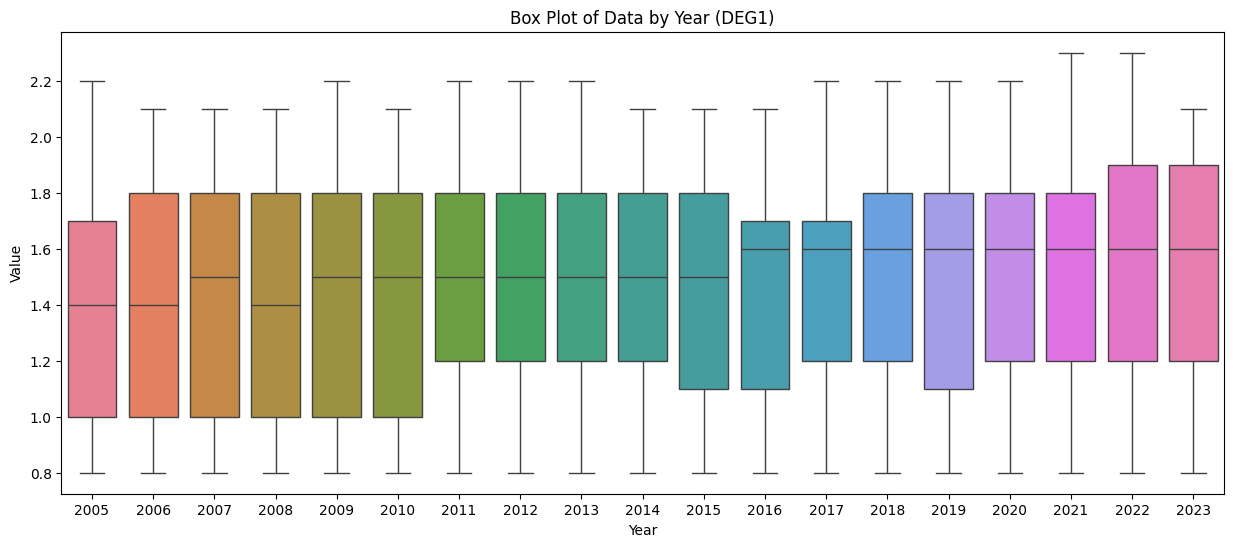

In [35]:
# plot the box plot for deg1
plt.figure(figsize=(15, 6)) # set the size of the plot
sns.boxplot(data=df_deg1) # create the box plot
plt.title('Box Plot of Data by Year (DEG1)') # set the title of the plot
plt.xlabel('Year')  # set the label of the x-axis
plt.ylabel('Value')  # set the label of the y-axis
plt.show()  # show the plot

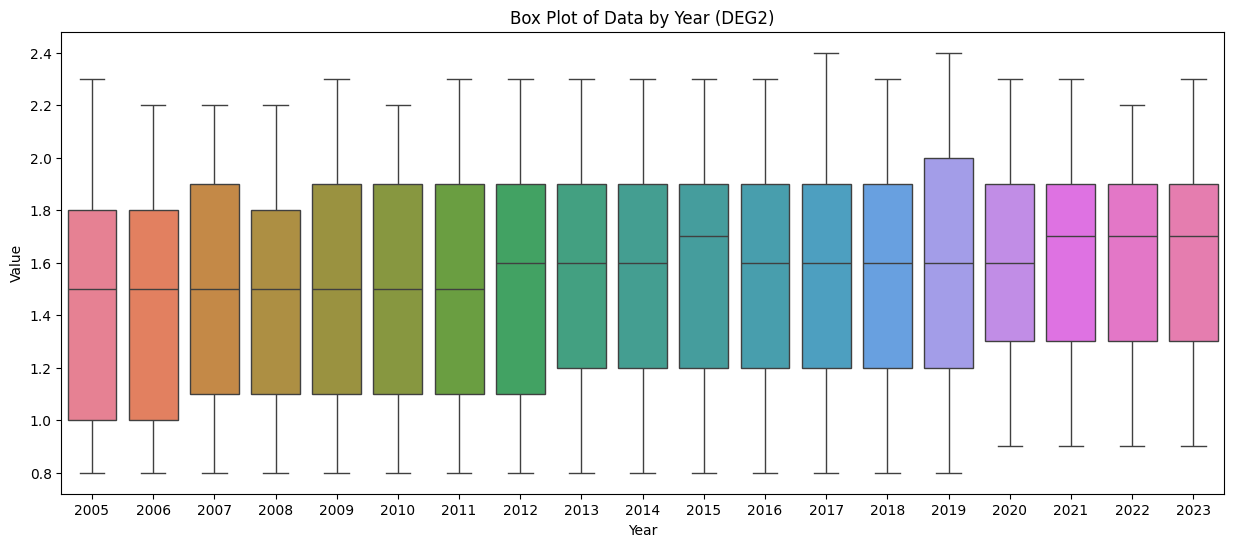

In [36]:
# plot the box plot for deg2
plt.figure(figsize=(15, 6)) # set the size of the plot
sns.boxplot(data=df_deg2) # create the box plot
plt.title('Box Plot of Data by Year (DEG2)') # set the title of the plot
plt.xlabel('Year')  # set the label of the x-axis
plt.ylabel('Value')  # set the label of the y-axis
plt.show()  # show the plot

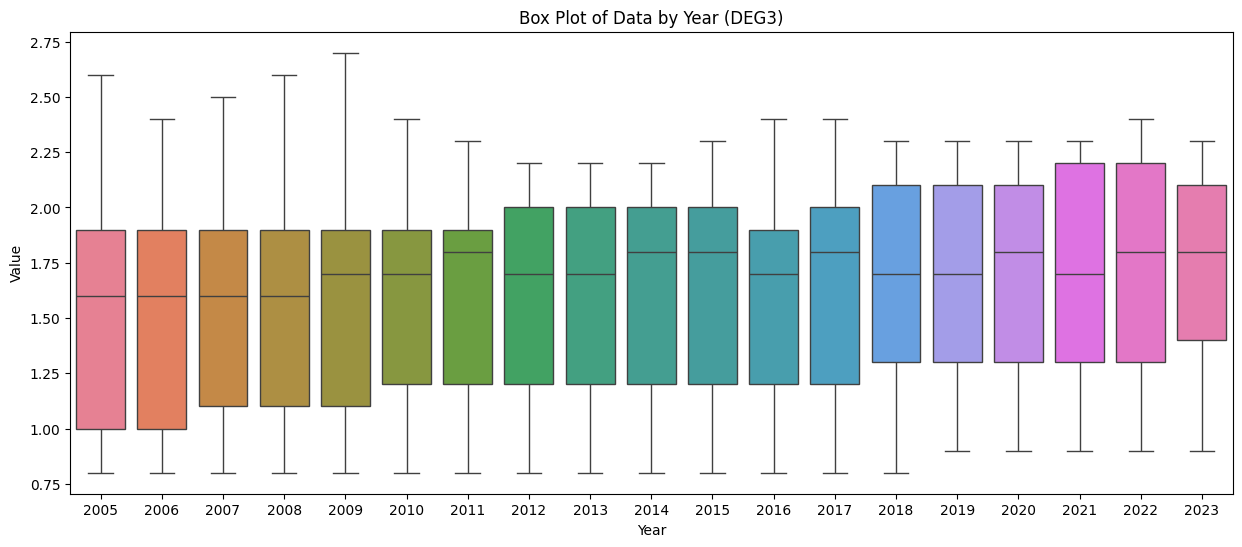

In [37]:
# plot the box plot for deg3
plt.figure(figsize=(15, 6)) # set the size of the plot
sns.boxplot(data=df_deg3) # create the box plot
plt.title('Box Plot of Data by Year (DEG3)') # set the title of the plot
plt.xlabel('Year')  # set the label of the x-axis
plt.ylabel('Value')  # set the label of the y-axis
plt.show()  # show the plot

#### Create One Plot with Three Subplots

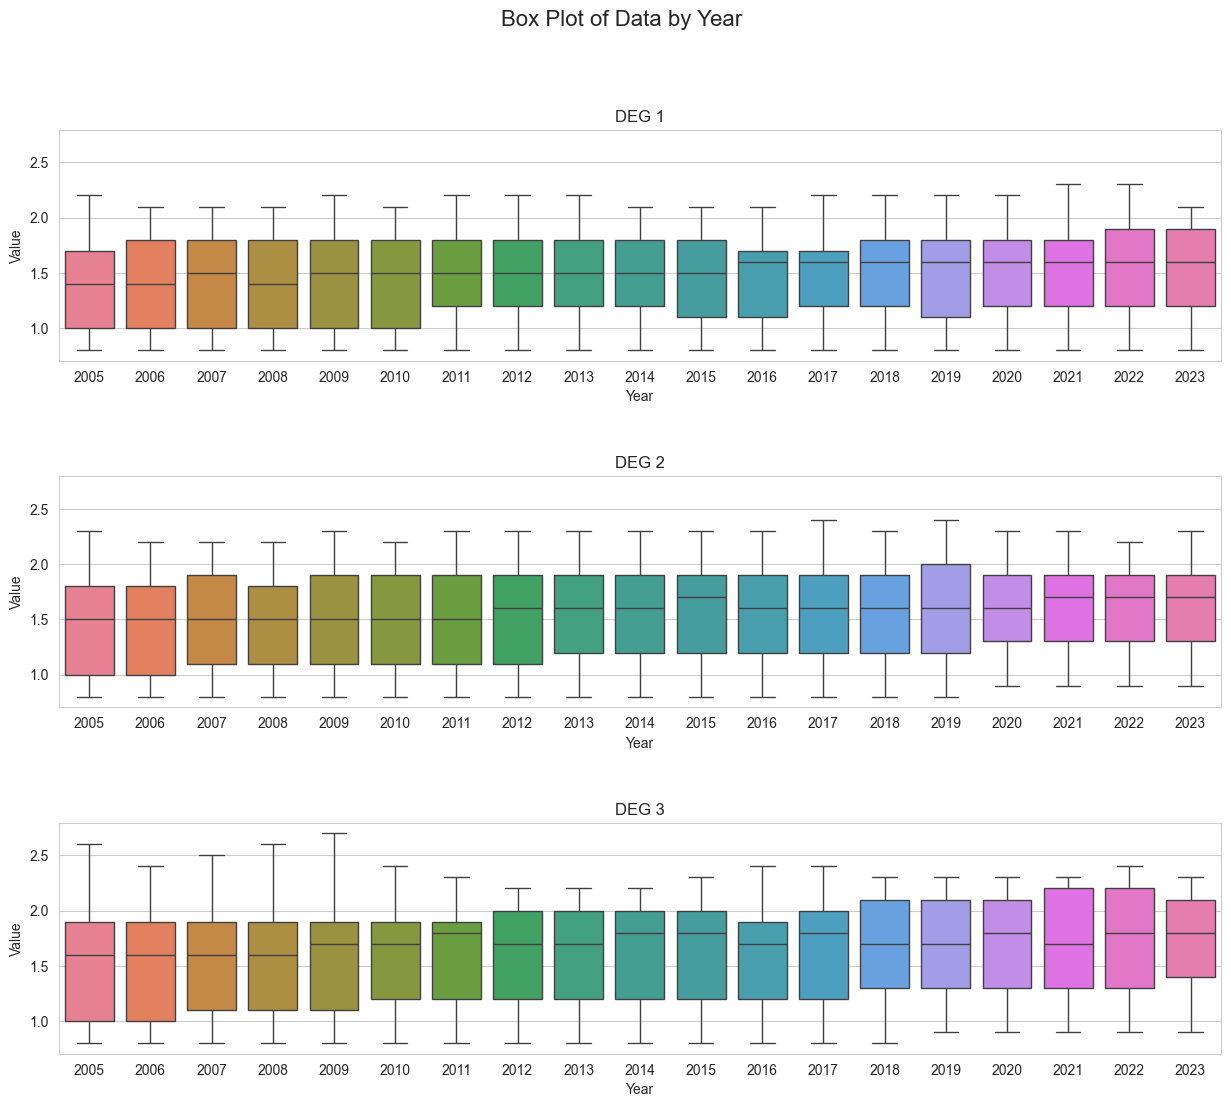

In [38]:
# set the style of the plots
sns.set_style("whitegrid")

# set three subplots and the size of the figure
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# set the title of the figure
plt.suptitle('Box Plot of Data by Year', fontsize=16)

# create the three box plots
sns.boxplot(data=df_deg1, ax=axes[0])  # set the deg1 data to the first subplot
axes[0].set_title('DEG 1')  # set the title of the first subplot
axes[0].set_xlabel('Year')  # set the x-axis label of the first subplot
axes[0].set_ylabel('Value')  # set the y-axis label of the first subplot

sns.boxplot(data=df_deg2, ax=axes[1])  # set the deg2 data to the second subplot
axes[1].set_title('DEG 2') # set the title of the second subplot
axes[1].set_xlabel('Year')  # set the x-axis label of the second subplot
axes[1].set_ylabel('Value') # set the y-axis label of the second subplot

sns.boxplot(data=df_deg3, ax=axes[2])  # set the deg3 data to the third subplot
axes[2].set_title('DEG 3') # set the title of the third subplot
axes[2].set_xlabel('Year')  # set the x-axis label of the third subplot
axes[2].set_ylabel('Value')  # set the y-axis label of the third subplot

# adjust the space between subplots
plt.subplots_adjust(hspace=0.5)

# set the same y-axis limit for all subplots
ylim = [min([ax.get_ylim()[0] for ax in axes.flatten()]),
        max([ax.get_ylim()[1] for ax in axes.flatten()])]

# set the y-axis limit for all subplots
for ax in axes.flatten():
    ax.set_ylim(ylim)

# show the plot
plt.show()


#### Line Chart of Mean and Standard Deviation
Showcasing Annual Mean Values and Variability

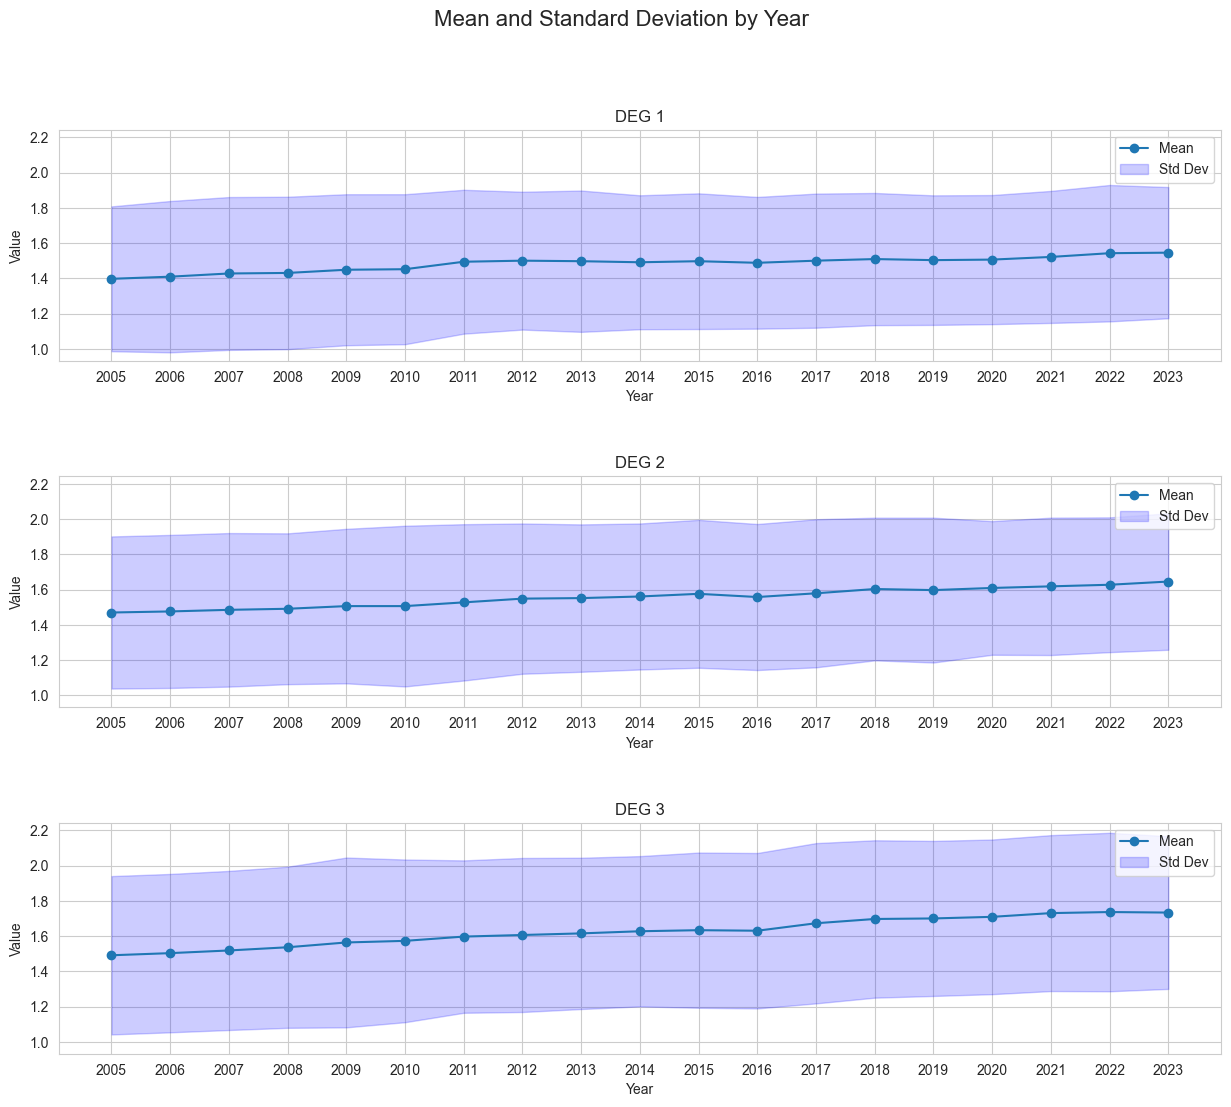

In [39]:
# set the style of the plots
sns.set_style("whitegrid")

# create a figure and axes
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# set the title of the figure
plt.suptitle('Mean and Standard Deviation by Year', fontsize=16)

# plot the data
axes[0].plot(mean_values_deg1.index, mean_values_deg1, label='Mean', marker='o') # plot the mean values for deg1
axes[0].fill_between(mean_values_deg1.index, mean_values_deg1 - std_values_deg1, mean_values_deg1 + std_values_deg1, color='b', alpha=0.2, label='Std Dev') # plot the standard deviation for deg1
axes[0].set_title('DEG 1') # title of the plot
axes[0].set_xlabel('Year') # x-axis label
axes[0].set_ylabel('Value') # y-axis label
axes[0].legend(loc='upper right') # legend location

axes[1].plot(mean_values_deg2.index, mean_values_deg2, label='Mean', marker='o') # plot the mean values for deg2
axes[1].fill_between(mean_values_deg2.index, mean_values_deg2 - std_values_deg2, mean_values_deg2 + std_values_deg2, color='b', alpha=0.2, label='Std Dev') # plot the standard deviation for deg2
axes[1].set_title('DEG 2') # title of the plot
axes[1].set_xlabel('Year') # x-axis label
axes[1].set_ylabel('Value') # y-axis label
axes[1].legend(loc='upper right') # legend location

axes[2].plot(mean_values_deg3.index, mean_values_deg3, label='Mean', marker='o') # plot the mean values for deg3
axes[2].fill_between(mean_values_deg3.index, mean_values_deg3 - std_values_deg3, mean_values_deg3 + std_values_deg3, color='b', alpha=0.2, label='Std Dev') # plot the standard deviation for deg3
axes[2].set_title('DEG 3') # title of the plot
axes[2].set_xlabel('Year') # x-axis label
axes[2].set_ylabel('Value') # y-axis label
axes[2].legend(loc='upper right') # legend location

# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# set the same y-axis limit for all subplots
ylim = [min([ax.get_ylim()[0] for ax in axes.flatten()]),
        max([ax.get_ylim()[1] for ax in axes.flatten()])]

# set the y-axis limit for all subplots
for ax in axes.flatten():
    ax.set_ylim(ylim)

# show the plot
plt.show()


#### Time Series Line Chart of Data for Countries

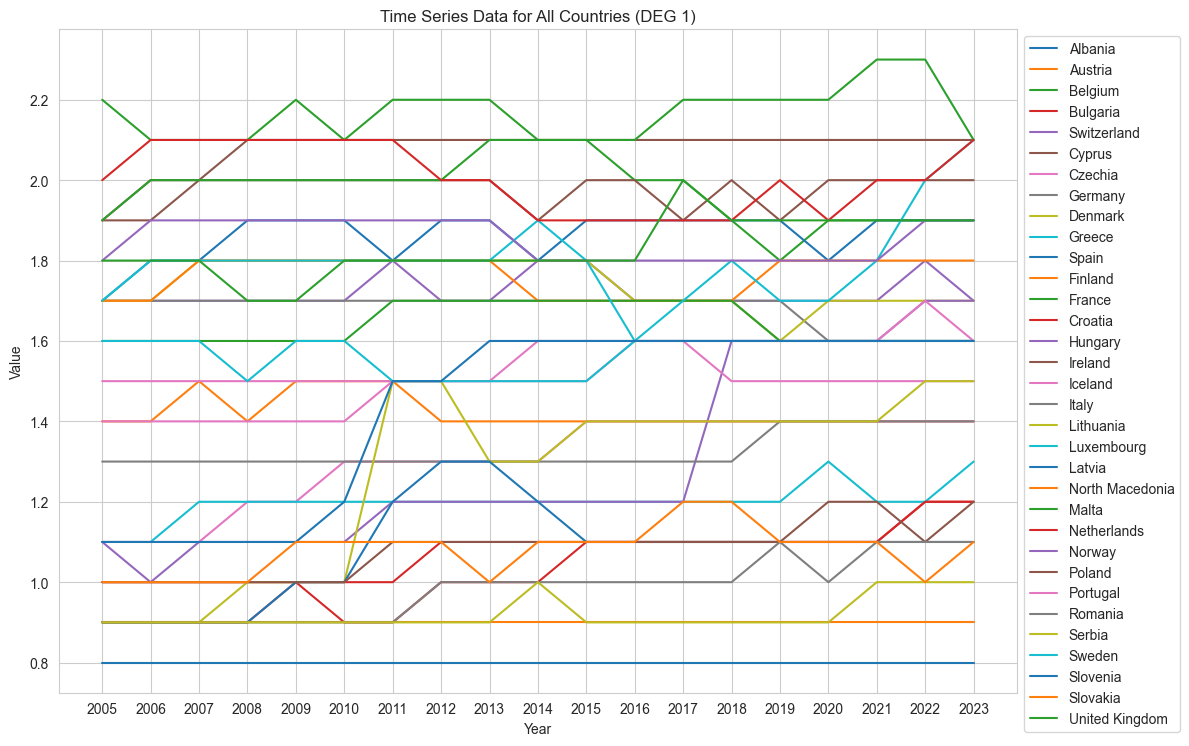

In [40]:
# set the style of the plots
sns.set_style("whitegrid")

# plot the line chart for all countries
plt.figure(figsize=(12,8)) # set the size of the plot
for i in range(len(df_deg1)):
    plt.plot(df_deg1.columns[1:], df_deg1.iloc[i, 1:], label=df_deg1.iloc[i, 0]) # plot the line chart for deg1 of each country
plt.title('Time Series Data for All Countries (DEG 1)') # set the title of the plot
plt.xlabel('Year') # set the x-axis label
plt.ylabel('Value') # set the y-axis label
plt.legend(loc='upper left', bbox_to_anchor=(1,1)) # set the location of the legend
plt.tight_layout() # adjust the layout of the plot
plt.show() # show the plot


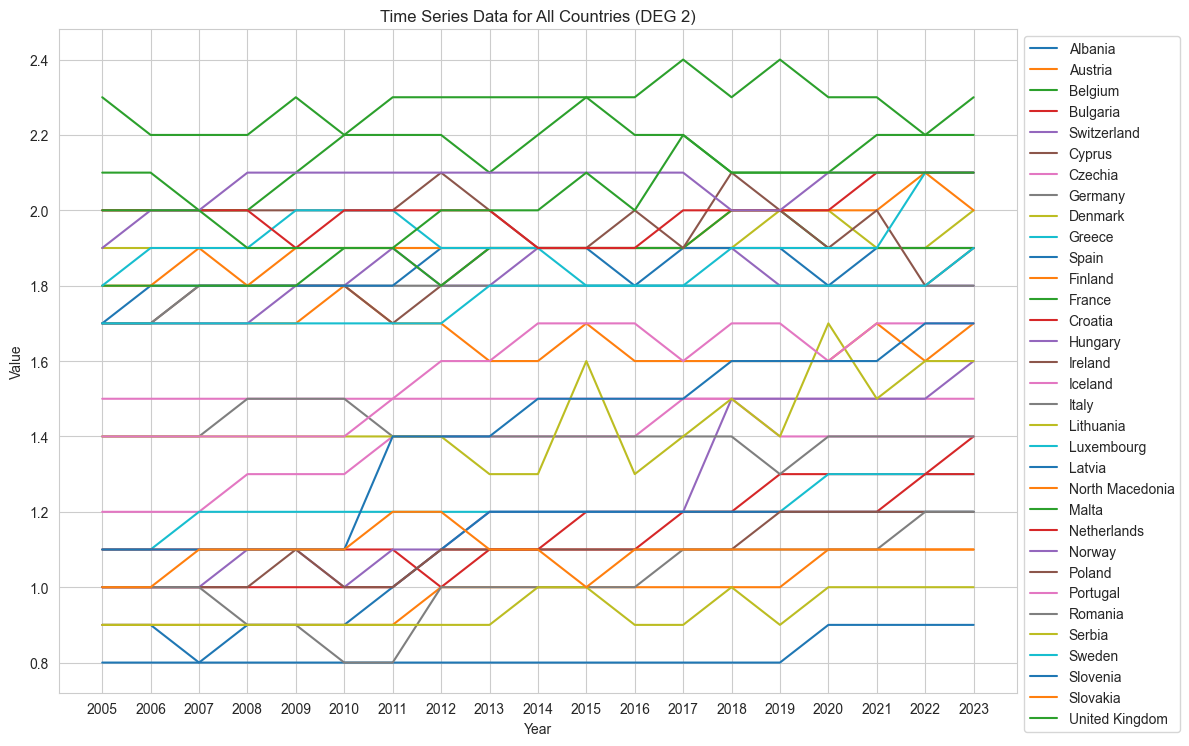

In [41]:
# set the style of the plots
sns.set_style("whitegrid")

# plot the line chart for all countries
plt.figure(figsize=(12,8)) # set the size of the plot
for i in range(len(df_deg2)):
    plt.plot(df_deg2.columns[1:], df_deg2.iloc[i, 1:], label=df_deg2.iloc[i, 0]) # plot the line chart for deg2 ofeach country
plt.title('Time Series Data for All Countries (DEG 2)') # set the title of the plot
plt.xlabel('Year') # set the x-axis label
plt.ylabel('Value') # set the y-axis label
plt.legend(loc='upper left', bbox_to_anchor=(1,1)) # set the location of the legend
plt.tight_layout() # adjust the layout of the plot
plt.show() # show the plot


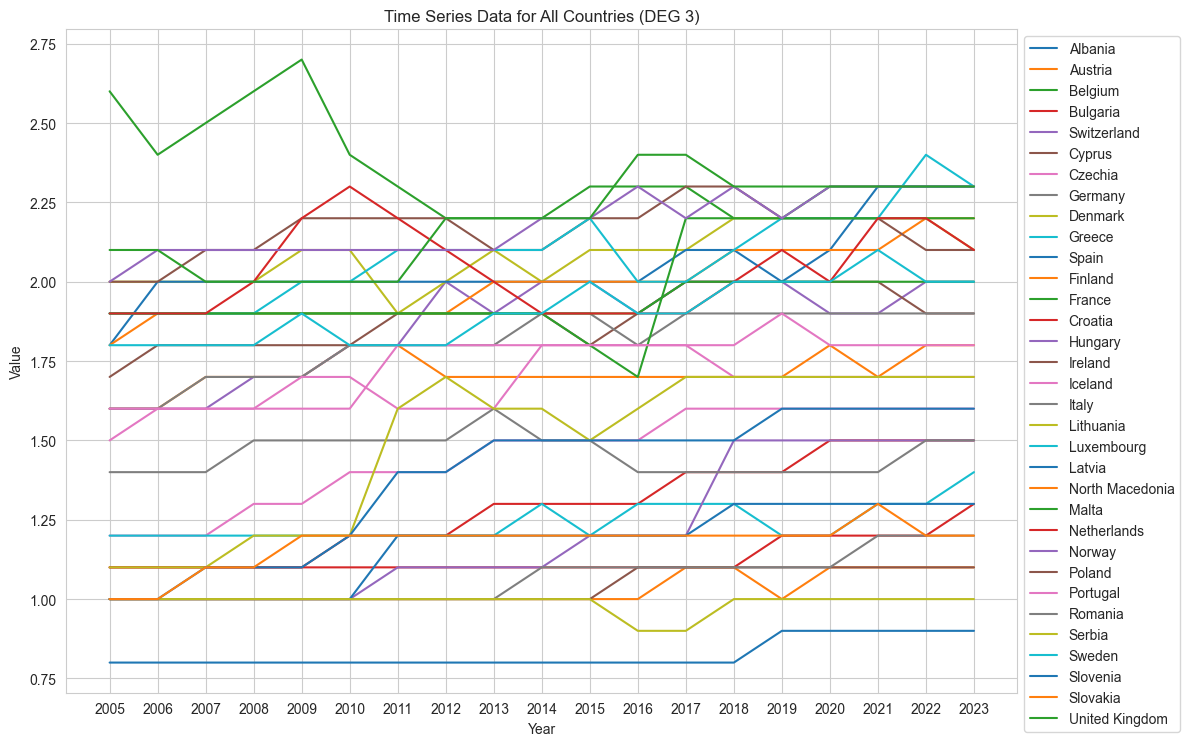

In [42]:
# set the style of the plots
sns.set_style("whitegrid")

# plot the line chart for all countries
plt.figure(figsize=(12,8)) # set the size of the plot
for i in range(len(df_deg3)):
    plt.plot(df_deg3.columns[1:], df_deg3.iloc[i, 1:], label=df_deg3.iloc[i, 0]) # plot the line chart for deg3 ofeach country
plt.title('Time Series Data for All Countries (DEG 3)') # set the title of the plot
plt.xlabel('Year') # set the x-axis label
plt.ylabel('Value') # set the y-axis label
plt.legend(loc='upper left', bbox_to_anchor=(1,1)) # set the location of the legend
plt.tight_layout() # adjust the layout of the plot
plt.show() # show the plot


### Heatmap
A heatmap can visually display the data values of each country across different years.

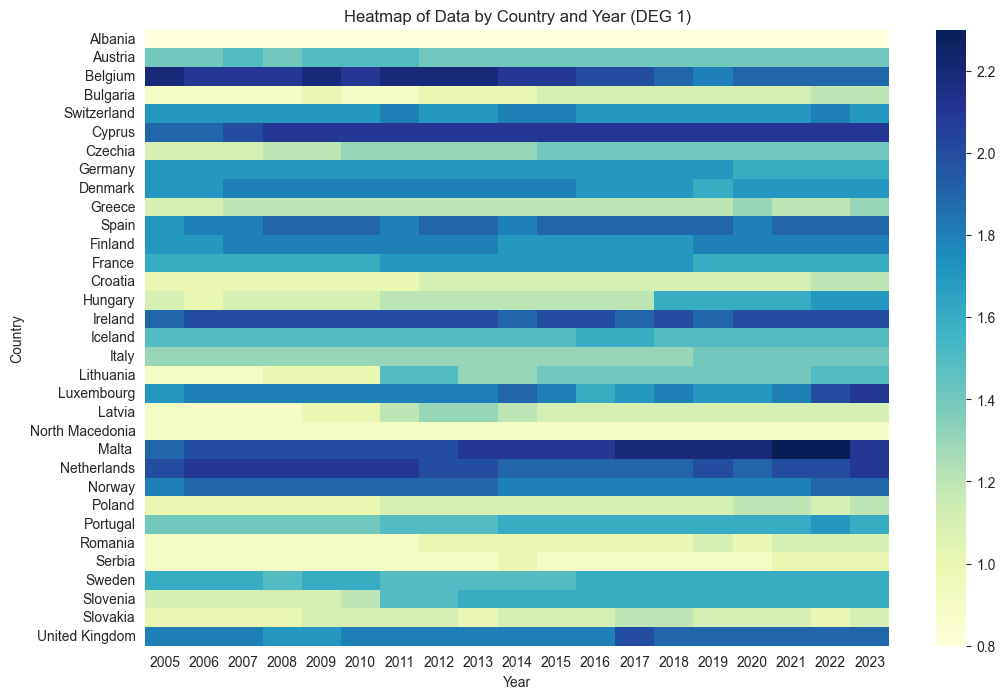

In [43]:
# set countries as index
df_deg1_heatmap = df_deg1.copy()
df_deg1_heatmap.set_index(df_deg1_heatmap.columns[0], inplace=True)

# heatmap for deg1
plt.figure(figsize=(12, 8)) # set the size of the plot
sns.heatmap(df_deg1_heatmap, cmap="YlGnBu", annot=False)  # create the heatmap
plt.title('Heatmap of Data by Country and Year (DEG 1)')  # set the title of the plot for deg1
plt.xlabel('Year')  # set the x-axis label
plt.ylabel('Country') # set the y-axis label
plt.show() # show the plot


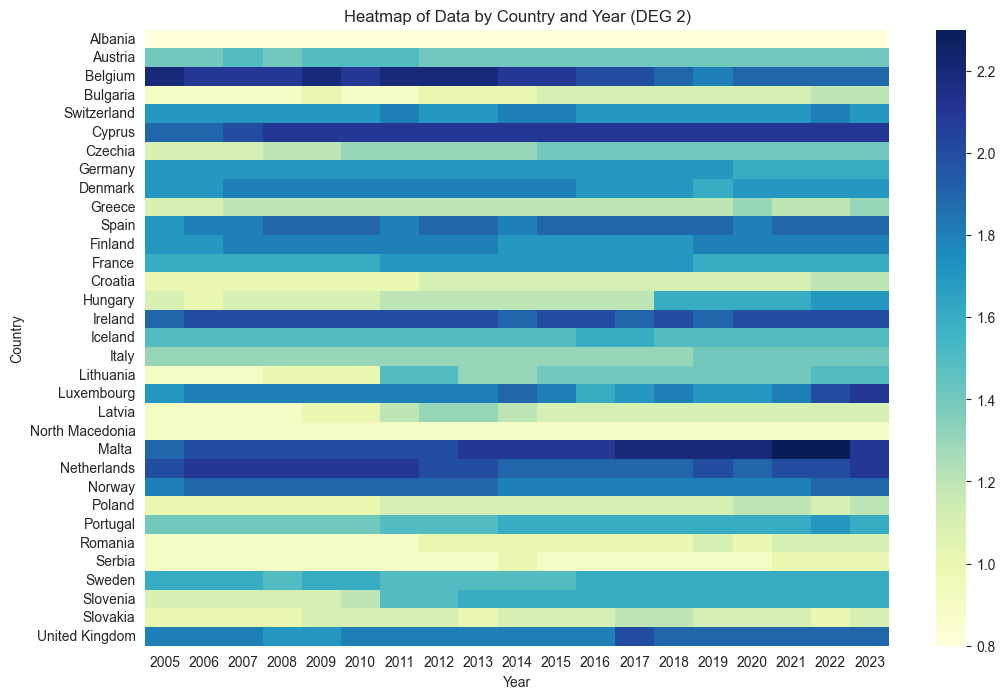

In [44]:
# set countries as index
df_deg2_heatmap = df_deg2.copy()
df_deg2_heatmap.set_index(df_deg2_heatmap.columns[0], inplace=True)

# heatmap for deg2
plt.figure(figsize=(12, 8)) # set the size of the plot
sns.heatmap(df_deg1_heatmap, cmap="YlGnBu", annot=False)  # create the heatmap
plt.title('Heatmap of Data by Country and Year (DEG 2)')  # set the title of the plot for deg2
plt.xlabel('Year')  # set the x-axis label
plt.ylabel('Country') # set the y-axis label
plt.show() # show the plot


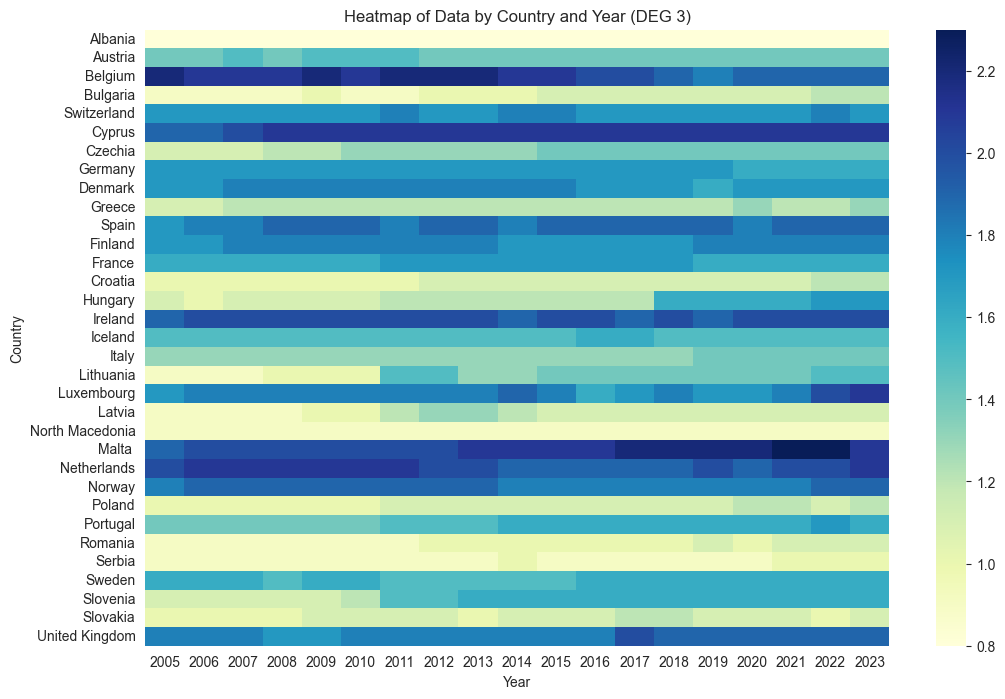

In [45]:
# set countries as index
df_deg3_heatmap = df_deg3.copy()
df_deg3_heatmap.set_index(df_deg3_heatmap.columns[0], inplace=True)

# heatmap for deg3
plt.figure(figsize=(12, 8)) # set the size of the plot
sns.heatmap(df_deg1_heatmap, cmap="YlGnBu", annot=False)  # create the heatmap
plt.title('Heatmap of Data by Country and Year (DEG 3)')  # set the title of the plot for deg3
plt.xlabel('Year')  # set the x-axis label
plt.ylabel('Country') # set the y-axis label
plt.show() # show the plot

## Modeling

### Convert Data for Moeling

In [46]:
# convert the data into a long format
df_deg1_model = pd.melt(df_deg1, id_vars=['country'], var_name='year', value_name='value') # deg1
df_deg2_model = pd.melt(df_deg2, id_vars=['country'], var_name='year', value_name='value') # deg2
df_deg3_model = pd.melt(df_deg3, id_vars=['country'], var_name='year', value_name='value') # deg3

# change the year column to numeric
df_deg1_model['year'] = pd.to_numeric(df_deg1_model['year']) # deg1
df_deg2_model['year'] = pd.to_numeric(df_deg2_model['year'])  # deg2
df_deg3_model['year'] = pd.to_numeric(df_deg3_model['year'])  # deg3

In [47]:
# check the dataframe
df_deg1_model

,country,year,value
0,Albania,2005,0.8
1,Austria,2005,1.4
2,Belgium,2005,2.2
3,Bulgaria,2005,0.9
4,Switzerland,2005,1.7
...,...,...,...
622,Serbia,2023,1.0
623,Sweden,2023,1.6
624,Slovenia,2023,1.6
625,Slovakia,2023,1.1


In [48]:
# create the lagged features
df_deg1_model['lag_1'] = df_deg1_model.groupby('country')['value'].shift(1)
df_deg1_model['lag_2'] = df_deg1_model.groupby('country')['value'].shift(2)

df_deg2_model['lag_1'] = df_deg2_model.groupby('country')['value'].shift(1)
df_deg2_model['lag_2'] = df_deg2_model.groupby('country')['value'].shift(2)

df_deg3_model['lag_1'] = df_deg3_model.groupby('country')['value'].shift(1)
df_deg3_model['lag_2'] = df_deg3_model.groupby('country')['value'].shift(2)

# drop the rows with NaN values because the first two years don't have lagged values
df_deg1_model.dropna(inplace=True)
df_deg2_model.dropna(inplace=True)
df_deg3_model.dropna(inplace=True)


In [49]:
# show the dataframe
df_deg1_model

,country,year,value,lag_1,lag_2
66,Albania,2007,0.8,0.8,0.8
67,Austria,2007,1.5,1.4,1.4
68,Belgium,2007,2.1,2.1,2.2
69,Bulgaria,2007,0.9,0.9,0.9
70,Switzerland,2007,1.7,1.7,1.7
...,...,...,...,...,...
622,Serbia,2023,1.0,1.0,1.0
623,Sweden,2023,1.6,1.6,1.6
624,Slovenia,2023,1.6,1.6,1.6
625,Slovakia,2023,1.1,1.0,1.1


### DEG1

In [50]:
# model list
models = {
    'Ridge': Ridge(), # ridge regression
    'Lasso': Lasso(), # lasso regression
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42), # random forest
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42), # gradient boosting
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42), # ada boost
    'SVR': SVR(kernel='rbf') # support vector regression
}

In [51]:
# split data into train and test sets
train = df_deg1_model[df_deg1_model['year'] < 2020]
test = df_deg1_model[df_deg1_model['year'] >= 2020]

X_train = train[['lag_1', 'lag_2']]
y_train = train['value']
X_test = test[['lag_1', 'lag_2']]
y_test = test['value']

In [52]:
# cross validation
tscv = TimeSeriesSplit(n_splits=5)

# store the scores
model_scores = {}

# loop through the models and train them
for name, model in models.items():
    # use cross validation to evaluate the model
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    mean_cv_score = -np.mean(cv_scores)  # take the mean of the negative MSE values
    
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict the test set
    
    test_mse = mean_squared_error(y_test, y_pred)  # MSE of the test set
    test_r2 = r2_score(y_test, y_pred)  # R^2 of the test set
    # Calculate AIC
    n = len(y_test)  # number of test samples
    rss = np.sum((y_test - y_pred) ** 2)  # residual sum of squares
    k = len(model._get_param_names())  # number of parameters, or specify manually based on the model
    aic = n * np.log(rss / n) + 2 * k  # AIC formula

    # store the scores of the models
    model_scores[name] = {
        'CV_MSE': mean_cv_score,
        'Test_MSE': test_mse,
        'Test_R2': test_r2,
        'AIC': aic
    }
    print(f"{name} - CV MSE: {mean_cv_score:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}, AIC: {aic:.4f}")

# print the best model
best_model = min(model_scores, key=lambda x: model_scores[x]['Test_MSE'])
print(f"Best model is: {best_model} with Test MSE: {model_scores[best_model]['Test_MSE']:.4f}, Test R^2: {model_scores[best_model]['Test_R2']:.4f}, AIC: {model_scores[best_model]['AIC']:.4f}")


Ridge - CV MSE: 0.0042, Test MSE: 0.0029, Test R^2: 0.9791, AIC: -756.7880
Lasso - CV MSE: 0.1493, Test MSE: 0.1393, Test R^2: -0.0176, AIC: -240.1827
RandomForest - CV MSE: 0.0044, Test MSE: 0.0032, Test R^2: 0.9769, AIC: -723.9794
GradientBoosting - CV MSE: 0.0044, Test MSE: 0.0031, Test R^2: 0.9775, AIC: -721.2024
AdaBoost - CV MSE: 0.0059, Test MSE: 0.0046, Test R^2: 0.9661, AIC: -699.1261
SVR - CV MSE: 0.0052, Test MSE: 0.0032, Test R^2: 0.9766, AIC: -736.0083
Best model is: Ridge with Test MSE: 0.0029, Test R^2: 0.9791, AIC: -756.7880


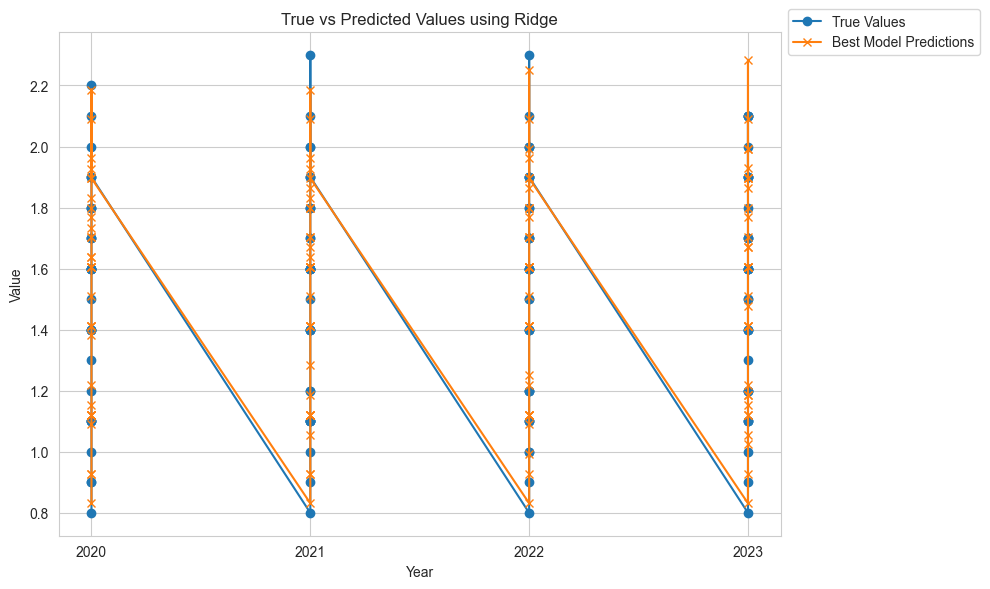

In [53]:
# plot the true vs predicted values of the best model
# generate predictions with the best model
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(test['year'], y_test, label='True Values', marker='o')
plt.plot(test['year'], y_pred_best, label='Best Model Predictions', marker='x')

# set title and labels
plt.title(f'True vs Predicted Values using {best_model}')
plt.xlabel('Year')
plt.ylabel('Value')

# set x-axis to display only integer years
plt.xticks(np.arange(min(test['year']), max(test['year'])+1, 1))  # adjusts the x-axis ticks

# move legend to the outside of the plot (right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# display the plot
plt.tight_layout()  # ensures everything fits well
plt.show()

#### Hyperparameter Tuning Using RandomizedSearchCV

In [54]:
# define the parameter grid
param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.5]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}

In [55]:
# store the best models
best_models = {}

# loop through the models and perform randomized search
for name, model in models.items():
    if param_grid[name]:
        print(f"Randomized Search for {name}...")
        random_search = RandomizedSearchCV(model, param_distributions=param_grid[name], cv=tscv, n_iter=3, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train, y_train)
        best_models[name] = random_search.best_estimator_
    else:
        best_models[name] = model  # if no parameters to tune, use the original model

Randomized Search for Ridge...
Randomized Search for Lasso...
Randomized Search for RandomForest...
Randomized Search for GradientBoosting...
Randomized Search for AdaBoost...
Randomized Search for SVR...


In [56]:
# record the scores
model_scores = {}

for name, model in best_models.items():
    # performing cross-validation with the tuned model
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    mean_cv_score = -np.mean(cv_scores)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    # Calculate AIC
    n = len(y_test)  # number of test samples
    rss = np.sum((y_test - y_pred) ** 2)  # residual sum of squares
    k = len(model._get_param_names())  # number of parameters, or specify manually based on the model
    aic = n * np.log(rss / n) + 2 * k  # AIC formula

    # store the scores of the models
    model_scores[name] = {
        'CV_MSE': mean_cv_score,
        'Test_MSE': test_mse,
        'Test_R2': test_r2,
        'AIC': aic
    }
    print(f"{name} - CV MSE: {mean_cv_score:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}, AIC: {aic:.4f}")

# print the best model
best_model = min(model_scores, key=lambda x: model_scores[x]['Test_MSE'])
print(f"Best model is: {best_model} with Test MSE: {model_scores[best_model]['Test_MSE']:.4f}, Test R^2: {model_scores[best_model]['Test_R2']:.4f}, AIC: {model_scores[best_model]['AIC']:.4f}")


Ridge - CV MSE: 0.0040, Test MSE: 0.0028, Test R^2: 0.9793, AIC: -758.3780
Lasso - CV MSE: 0.0516, Test MSE: 0.0602, Test R^2: 0.5604, AIC: -350.9870
RandomForest - CV MSE: 0.0044, Test MSE: 0.0032, Test R^2: 0.9769, AIC: -723.8378
GradientBoosting - CV MSE: 0.0045, Test MSE: 0.0034, Test R^2: 0.9754, AIC: -709.7303
AdaBoost - CV MSE: 0.0054, Test MSE: 0.0053, Test R^2: 0.9615, AIC: -682.3496
SVR - CV MSE: 0.0045, Test MSE: 0.0031, Test R^2: 0.9772, AIC: -739.7942
Best model is: Ridge with Test MSE: 0.0028, Test R^2: 0.9793, AIC: -758.3780


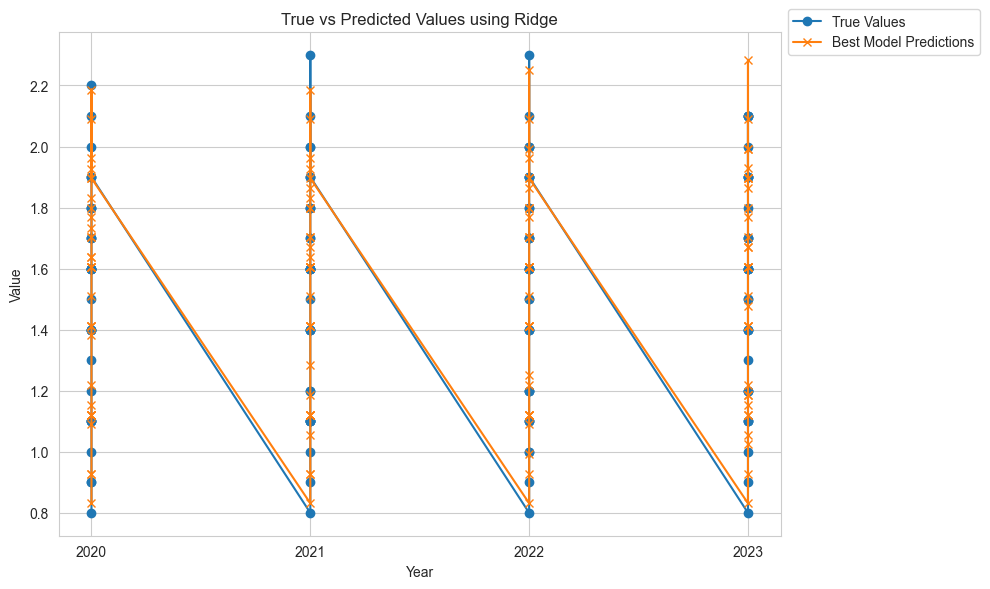

In [57]:
# plot the true vs predicted values of the best model
# generate predictions with the best model
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(test['year'], y_test, label='True Values', marker='o')
plt.plot(test['year'], y_pred_best, label='Best Model Predictions', marker='x')

# set title and labels
plt.title(f'True vs Predicted Values using {best_model}')
plt.xlabel('Year')
plt.ylabel('Value')

# set x-axis to display only integer years
plt.xticks(np.arange(min(test['year']), max(test['year'])+1, 1))  # adjusts the x-axis ticks

# move legend to the outside of the plot (right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# display the plot
plt.tight_layout()  # ensures everything fits well
plt.show()

### DEG2

In [58]:
# model list
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

In [59]:
# split data into train and test sets
train = df_deg2_model[df_deg2_model['year'] < 2020]
test = df_deg2_model[df_deg2_model['year'] >= 2020]

X_train = train[['lag_1', 'lag_2']]
y_train = train['value']
X_test = test[['lag_1', 'lag_2']]
y_test = test['value']

In [60]:
# perform cross-validation and record the scores
tscv = TimeSeriesSplit(n_splits=5)
model_scores = {}

# loop through the models and perform cross-validation
for name, model in models.items():
    # performing cross-validation with the tuned model
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    mean_cv_score = -np.mean(cv_scores)  # convert to positive MSE
    
    model.fit(X_train, y_train)  # fit the model on the entire training set
    y_pred = model.predict(X_test)  # predict the test set
    
    test_mse = mean_squared_error(y_test, y_pred)  # MSE of the test set
    test_r2 = r2_score(y_test, y_pred)  # R^2 of the test set
 # Calculate AIC
    n = len(y_test)  # number of test samples
    rss = np.sum((y_test - y_pred) ** 2)  # residual sum of squares
    k = len(model._get_param_names())  # number of parameters, or specify manually based on the model
    aic = n * np.log(rss / n) + 2 * k  # AIC formula

    # store the scores of the models
    model_scores[name] = {
        'CV_MSE': mean_cv_score,
        'Test_MSE': test_mse,
        'Test_R2': test_r2,
        'AIC': aic
    }
    print(f"{name} - CV MSE: {mean_cv_score:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}, AIC: {aic:.4f}")

# print the best model
best_model = min(model_scores, key=lambda x: model_scores[x]['Test_MSE'])
print(f"Best model is: {best_model} with Test MSE: {model_scores[best_model]['Test_MSE']:.4f}, Test R^2: {model_scores[best_model]['Test_R2']:.4f}, AIC: {model_scores[best_model]['AIC']:.4f}")


Ridge - CV MSE: 0.0039, Test MSE: 0.0030, Test R^2: 0.9791, AIC: -750.6764
Lasso - CV MSE: 0.1761, Test MSE: 0.1502, Test R^2: -0.0442, AIC: -230.2358
RandomForest - CV MSE: 0.0048, Test MSE: 0.0039, Test R^2: 0.9731, AIC: -697.0304
GradientBoosting - CV MSE: 0.0048, Test MSE: 0.0036, Test R^2: 0.9749, AIC: -700.5145
AdaBoost - CV MSE: 0.0057, Test MSE: 0.0050, Test R^2: 0.9653, AIC: -689.4455
SVR - CV MSE: 0.0047, Test MSE: 0.0030, Test R^2: 0.9789, AIC: -743.5202
Best model is: Ridge with Test MSE: 0.0030, Test R^2: 0.9791, AIC: -750.6764


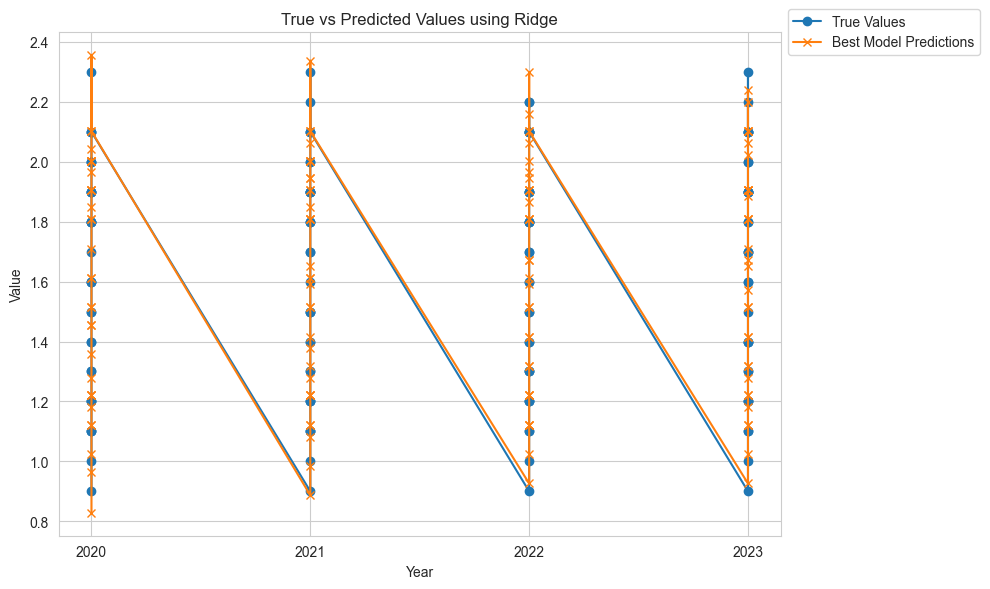

In [61]:
# plot the true vs predicted values of the best model
# generate predictions with the best model
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(test['year'], y_test, label='True Values', marker='o')
plt.plot(test['year'], y_pred_best, label='Best Model Predictions', marker='x')

# set title and labels
plt.title(f'True vs Predicted Values using {best_model}')
plt.xlabel('Year')
plt.ylabel('Value')

# set x-axis to display only integer years
plt.xticks(np.arange(min(test['year']), max(test['year'])+1, 1))  # adjusts the x-axis ticks

# move legend to the outside of the plot (right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# display the plot
plt.tight_layout()  # ensures everything fits well
plt.show()

#### Hyperparameter Tuning Using RandomizedSearchCV

In [62]:
# define the parameter grid
param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.5]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}

In [63]:
# record the results of each model
best_models = {}

# perform randomized search for each model
for name, model in models.items():
    if param_grid[name]:
        print(f"Randomized Search for {name}...")
        random_search = RandomizedSearchCV(model, param_distributions=param_grid[name], cv=tscv, n_iter=3, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train, y_train)
        best_models[name] = random_search.best_estimator_
    else:
        best_models[name] = model  # if no parameters to tune, use the original model

Randomized Search for Ridge...
Randomized Search for Lasso...
Randomized Search for RandomForest...
Randomized Search for GradientBoosting...
Randomized Search for AdaBoost...
Randomized Search for SVR...


In [64]:
# record the results of each model
model_scores = {}

for name, model in best_models.items():
    # perform cross-validation with the tuned model
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    mean_cv_score = -np.mean(cv_scores)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    # Calculate AIC
    n = len(y_test)  # number of test samples
    rss = np.sum((y_test - y_pred) ** 2)  # residual sum of squares
    k = len(model._get_param_names())  # number of parameters, or specify manually based on the model
    aic = n * np.log(rss / n) + 2 * k  # AIC formula

    # store the scores of the models
    model_scores[name] = {
        'CV_MSE': mean_cv_score,
        'Test_MSE': test_mse,
        'Test_R2': test_r2,
        'AIC': aic
    }
    print(f"{name} - CV MSE: {mean_cv_score:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}, AIC: {aic:.4f}")

# print the best model
best_model = min(model_scores, key=lambda x: model_scores[x]['Test_MSE'])
print(f"Best model is: {best_model} with Test MSE: {model_scores[best_model]['Test_MSE']:.4f}, Test R^2: {model_scores[best_model]['Test_R2']:.4f}, AIC: {model_scores[best_model]['AIC']:.4f}")


Ridge - CV MSE: 0.0038, Test MSE: 0.0031, Test R^2: 0.9784, AIC: -745.9284
Lasso - CV MSE: 0.0551, Test MSE: 0.0496, Test R^2: 0.6551, AIC: -376.4630
RandomForest - CV MSE: 0.0048, Test MSE: 0.0038, Test R^2: 0.9736, AIC: -699.7893
GradientBoosting - CV MSE: 0.0051, Test MSE: 0.0040, Test R^2: 0.9719, AIC: -685.2763
AdaBoost - CV MSE: 0.0057, Test MSE: 0.0050, Test R^2: 0.9653, AIC: -689.4455
SVR - CV MSE: 0.0041, Test MSE: 0.0039, Test R^2: 0.9732, AIC: -711.8024
Best model is: Ridge with Test MSE: 0.0031, Test R^2: 0.9784, AIC: -745.9284


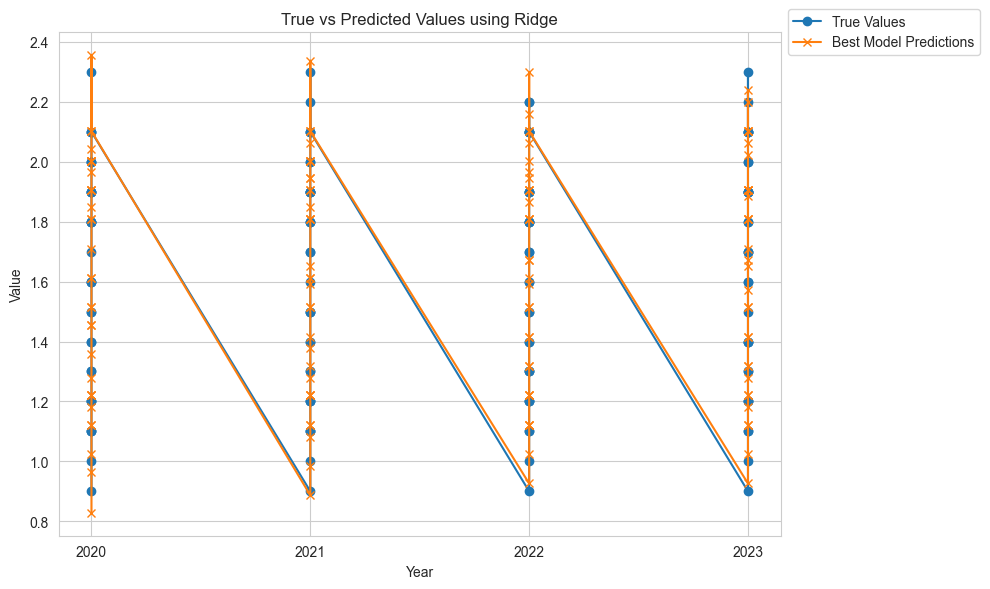

In [65]:
# plot the true vs predicted values of the best model
# generate predictions with the best model
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(test['year'], y_test, label='True Values', marker='o')
plt.plot(test['year'], y_pred_best, label='Best Model Predictions', marker='x')

# set title and labels
plt.title(f'True vs Predicted Values using {best_model}')
plt.xlabel('Year')
plt.ylabel('Value')

# set x-axis to display only integer years
plt.xticks(np.arange(min(test['year']), max(test['year'])+1, 1))  # adjusts the x-axis ticks

# move legend to the outside of the plot (right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# display the plot
plt.tight_layout()  # ensures everything fits well
plt.show()

### DEG3

In [66]:
# model list
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

In [67]:
# split the data into training and testing sets
train = df_deg3_model[df_deg3_model['year'] < 2020]
test = df_deg3_model[df_deg3_model['year'] >= 2020]

X_train = train[['lag_1', 'lag_2']]
y_train = train['value']
X_test = test[['lag_1', 'lag_2']]
y_test = test['value']

In [68]:
# perform cross-validation and record the scores
tscv = TimeSeriesSplit(n_splits=5)
model_scores = {}

# train each model and record the scores
for name, model in models.items():
    # perform cross-validation with the original model
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    mean_cv_score = -np.mean(cv_scores)  # convert to positive MSE
    
    model.fit(X_train, y_train)  # fit the model on the training data
    y_pred = model.predict(X_test)  # predict the values on the testing data
    
    test_mse = mean_squared_error(y_test, y_pred)  # MSE of the testing data
    test_r2 = r2_score(y_test, y_pred)  # R^2 of the testing data
    # Calculate AIC
    n = len(y_test)  # number of test samples
    rss = np.sum((y_test - y_pred) ** 2)  # residual sum of squares
    k = len(model._get_param_names())  # number of parameters, or specify manually based on the model
    aic = n * np.log(rss / n) + 2 * k  # AIC formula

    # store the scores of the models
    model_scores[name] = {
        'CV_MSE': mean_cv_score,
        'Test_MSE': test_mse,
        'Test_R2': test_r2,
        'AIC': aic
    }
    print(f"{name} - CV MSE: {mean_cv_score:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}, AIC: {aic:.4f}")

# print the best model
best_model = min(model_scores, key=lambda x: model_scores[x]['Test_MSE'])
print(f"Best model is: {best_model} with Test MSE: {model_scores[best_model]['Test_MSE']:.4f}, Test R^2: {model_scores[best_model]['Test_R2']:.4f}, AIC: {model_scores[best_model]['AIC']:.4f}")


Ridge - CV MSE: 0.0057, Test MSE: 0.0027, Test R^2: 0.9858, AIC: -765.8305
Lasso - CV MSE: 0.1945, Test MSE: 0.2020, Test R^2: -0.0690, AIC: -191.1329
RandomForest - CV MSE: 0.0063, Test MSE: 0.0037, Test R^2: 0.9802, AIC: -701.9485
GradientBoosting - CV MSE: 0.0063, Test MSE: 0.0034, Test R^2: 0.9818, AIC: -706.5425
AdaBoost - CV MSE: 0.0091, Test MSE: 0.0059, Test R^2: 0.9690, AIC: -668.3743
SVR - CV MSE: 0.0067, Test MSE: 0.0041, Test R^2: 0.9782, AIC: -703.2320
Best model is: Ridge with Test MSE: 0.0027, Test R^2: 0.9858, AIC: -765.8305


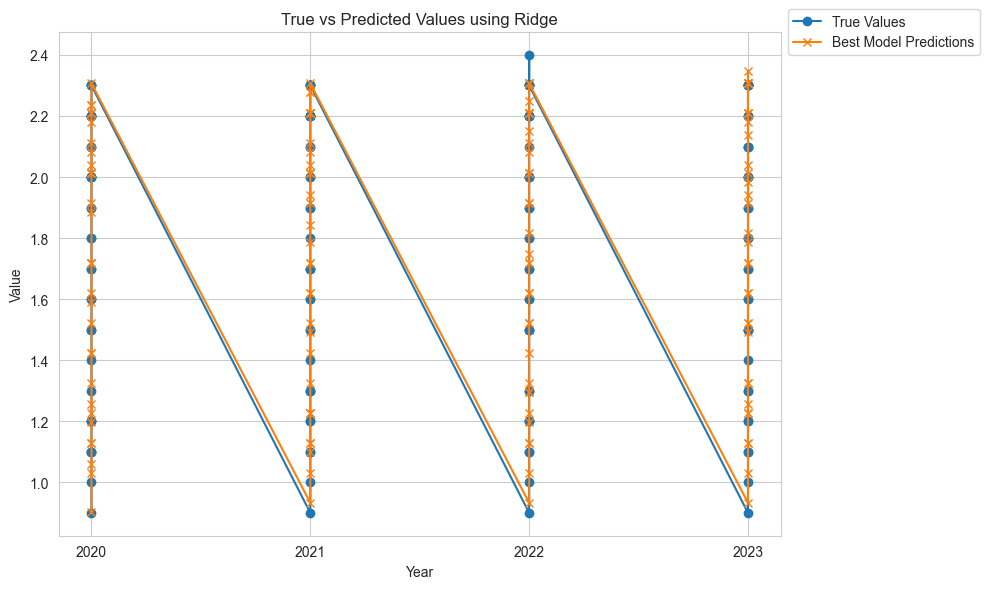

In [69]:
# plot the true vs predicted values of the best model
# generate predictions with the best model
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(test['year'], y_test, label='True Values', marker='o')
plt.plot(test['year'], y_pred_best, label='Best Model Predictions', marker='x')

# set title and labels
plt.title(f'True vs Predicted Values using {best_model}')
plt.xlabel('Year')
plt.ylabel('Value')

# set x-axis to display only integer years
plt.xticks(np.arange(min(test['year']), max(test['year'])+1, 1))  # adjusts the x-axis ticks

# move legend to the outside of the plot (right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# display the plot
plt.tight_layout()  # ensures everything fits well
plt.show()

#### Hyperparameter Tuning Using RandomizedSearchCV

In [70]:
# define the parameter grid
param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.5]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}

In [71]:
# record the results of each model
best_models = {}

# perform randomized search for each model
for name, model in models.items():
    if param_grid[name]:
        print(f"Randomized Search for {name}...")
        random_search = RandomizedSearchCV(model, param_distributions=param_grid[name], cv=tscv, n_iter=3, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train, y_train)
        best_models[name] = random_search.best_estimator_
    else:
        best_models[name] = model  # if no parameters to tune, use the original model

Randomized Search for Ridge...
Randomized Search for Lasso...
Randomized Search for RandomForest...
Randomized Search for GradientBoosting...
Randomized Search for AdaBoost...
Randomized Search for SVR...


In [72]:
# record the results of each model
model_scores = {}

for name, model in best_models.items():
    # perform cross-validation with the tuned model
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    mean_cv_score = -np.mean(cv_scores)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    # Calculate AIC
    n = len(y_test)  # number of test samples
    rss = np.sum((y_test - y_pred) ** 2)  # residual sum of squares
    k = len(model._get_param_names())  # number of parameters, or specify manually based on the model
    aic = n * np.log(rss / n) + 2 * k  # AIC formula

    # store the scores of the models
    model_scores[name] = {
        'CV_MSE': mean_cv_score,
        'Test_MSE': test_mse,
        'Test_R2': test_r2,
        'AIC': aic
    }
    print(f"{name} - CV MSE: {mean_cv_score:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}, AIC: {aic:.4f}")

# print the best model
best_model = min(model_scores, key=lambda x: model_scores[x]['Test_MSE'])
print(f"Best model is: {best_model} with Test MSE: {model_scores[best_model]['Test_MSE']:.4f}, Test R^2: {model_scores[best_model]['Test_R2']:.4f}, AIC: {model_scores[best_model]['AIC']:.4f}")


Ridge - CV MSE: 0.0054, Test MSE: 0.0027, Test R^2: 0.9856, AIC: -763.3269
Lasso - CV MSE: 0.0524, Test MSE: 0.0555, Test R^2: 0.7064, AIC: -361.7307
RandomForest - CV MSE: 0.0063, Test MSE: 0.0037, Test R^2: 0.9802, AIC: -701.9738
GradientBoosting - CV MSE: 0.0066, Test MSE: 0.0040, Test R^2: 0.9789, AIC: -687.4420
AdaBoost - CV MSE: 0.0090, Test MSE: 0.0051, Test R^2: 0.9730, AIC: -686.8386
SVR - CV MSE: 0.0068, Test MSE: 0.0030, Test R^2: 0.9842, AIC: -745.4097
Best model is: Ridge with Test MSE: 0.0027, Test R^2: 0.9856, AIC: -763.3269


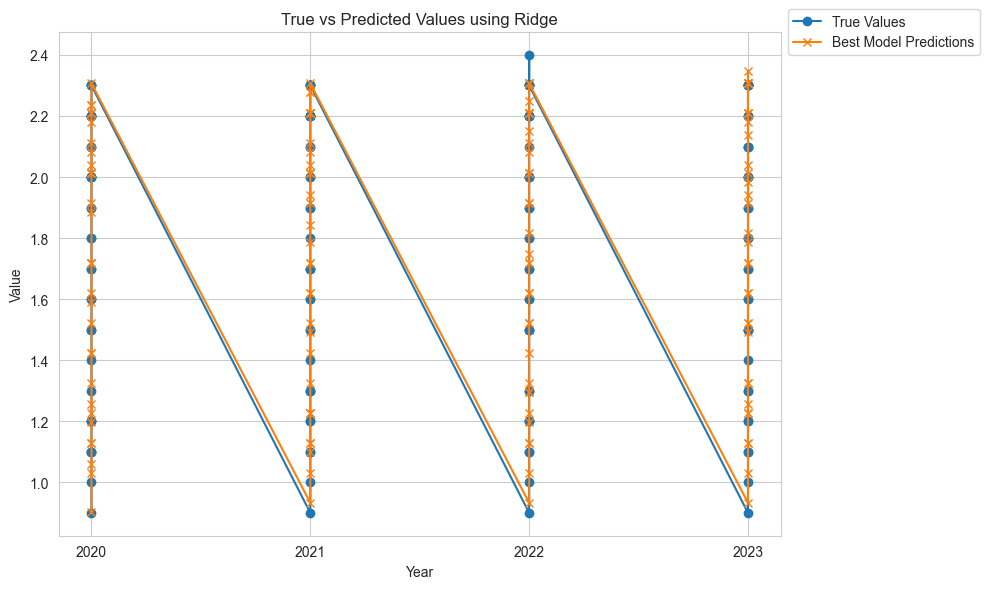

In [73]:
# plot the true vs predicted values of the best model
# generate predictions with the best model
best_model_instance = models[best_model]
y_pred_best = best_model_instance.predict(X_test)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(test['year'], y_test, label='True Values', marker='o')
plt.plot(test['year'], y_pred_best, label='Best Model Predictions', marker='x')

# set title and labels
plt.title(f'True vs Predicted Values using {best_model}')
plt.xlabel('Year')
plt.ylabel('Value')

# set x-axis to display only integer years
plt.xticks(np.arange(min(test['year']), max(test['year'])+1, 1))  # adjusts the x-axis ticks

# move legend to the outside of the plot (right side)
plt.legend(loc='center left', bbox_to_anchor=(1, 1))

# display the plot
plt.tight_layout()  # ensures everything fits well
plt.show()